## Importing Libraries
This section imports all the required libraries for data manipulation, visualization, preprocessing, model training, and evaluation.

## Importing Libraries
This section imports all the required libraries for data manipulation, visualization, preprocessing, model training, and evaluation.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression



## Load and Explore Dataset
This section loads the dataset from a URL and performs exploratory data analysis such as summary statistics

## Data Preprocessing
This section preprocesses the data by defining pipelines for numerical and categorical data, applying transformations, splitting the data into training and testing sets, and addressing class imbalance using SMOTE.

In [4]:
# Define numerical and categorical columns
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = df.select_dtypes(include=['object']).drop(columns=['Attrition']).columns.tolist()

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the transformations
X = df.drop(columns=['Attrition'])
y = df['Attrition'].apply(lambda x: 1 if x == 'Yes' else 0)

X_processed = preprocessor.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Address class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)


C:\New folder\Lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


## Model Training and Hyperparameter Tuning
This section defines the logistic regression model, specifies the hyperparameter grid, performs grid search with cross-validation to find the best hyperparameters, and selects the best logistic regression model.

In [5]:
# Define the logistic regression model
log_reg = LogisticRegression(max_iter=1000)

# Define the hyperparameter grid
param_grid_lr = {'C': [0.01, 0.1, 1, 10, 100]}

# Perform grid search with cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search_lr = GridSearchCV(log_reg, param_grid_lr, cv=kfold, scoring='f1')
grid_search_lr.fit(X_train_res, y_train_res)

# Best Logistic Regression model
best_lr = grid_search_lr.best_estimator_
print(f"Logistic Regression Best Params: {grid_search_lr.best_params_}")


Logistic Regression Best Params: {'C': 100}


## Model Evaluation
This section evaluates the best logistic regression model on the test set using various metrics such as accuracy, precision, recall, F1 score, and ROC-AUC score. It also displays the classification report and confusion matrix.

In [ ]:
# Evaluate the Logistic Regression model
y_pred = best_lr.predict(X_test)
y_prob = best_lr.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Display classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


## Cross-Validation Results
This section computes cross-validation scores for the best logistic regression model along with their mean and standard deviation.

In [7]:
# Cross-validation scores
cv_results = cross_val_score(best_lr, X_train_res, y_train_res, cv=kfold, scoring='f1')

print(f"Cross-Validation F1 Scores: {cv_results}")
print(f"Mean CV F1 Score: {cv_results.mean():.4f}")
print(f"Standard Deviation of CV F1 Scores: {cv_results.std():.4f}")


Cross-Validation F1 Scores: [0.81538462 0.84343434 0.79       0.81122449 0.82517483]
Mean CV F1 Score: 0.8170
Standard Deviation of CV F1 Scores: 0.0175


## Feature Importance
This retrieves the feature names after preprocessing, combines them, and calculates the coefficients of the logistic regression model. Then, creates a DataFrame to store the feature importances and sorts it by absolute importance. Finally, it prints the top 10 features based on their importance.

In [8]:
# Get feature names after preprocessing
num_features = numerical_cols
cat_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_cols)
all_feature_names = np.concatenate([num_features, cat_features])

# Get the coefficients of the logistic regression model
coefficients = best_lr.coef_.flatten()

# Create a DataFrame for feature importances
feat_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': coefficients
})

# Sort by absolute importance
feat_importance_df = feat_importance_df.reindex(feat_importance_df.Importance.abs().sort_values(ascending=False).index)

# Display the top 10 features
print("\nTop 10 Features:")
print(feat_importance_df.head(10))



Top 10 Features:
                              Feature  Importance
36            JobRole_Human Resources    5.900413
29                   Department_Sales    3.627470
28  Department_Research & Development    3.561708
43       JobRole_Sales Representative    3.389000
37      JobRole_Laboratory Technician    2.921349
46                       OverTime_Yes    2.488728
26   BusinessTravel_Travel_Frequently    2.434490
42            JobRole_Sales Executive    1.966839
45               MaritalStatus_Single    1.852468
41         JobRole_Research Scientist    1.691848


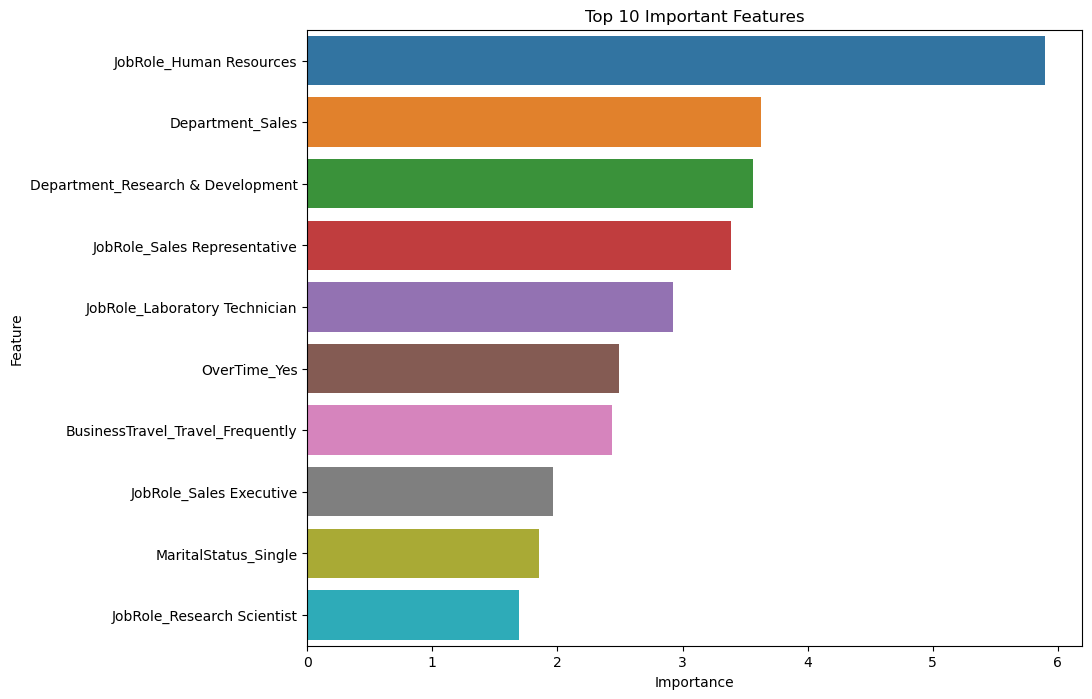

In [9]:
# Plot feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df.head(10))
plt.title('Top 10 Important Features')
plt.show()
